<a href="https://colab.research.google.com/github/sseunghyuns/AI_project/blob/main/invasive_species_monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import glob
import zipfile
from PIL import Image
import cv2

from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


---

# <font color='blue'>대회 소개</font>

### Invasive Species Monitoring
**Identify images of invasive hydrangea**  
https://www.kaggle.com/c/invasive-species-monitoring

---

***Description***

Tangles of kudzu overwhelm trees in Georgia while cane toads threaten habitats in over a dozen countries worldwide. These are just two invasive species of many which can have damaging effects on the environment, the economy, and even human health. Despite widespread impact, efforts to track the location and spread of invasive species are so costly that they’re difficult to undertake at scale.

Currently, ecosystem and plant distribution monitoring depends on expert knowledge. Trained scientists visit designated areas and take note of the species inhabiting them. Using such a highly qualified workforce is expensive, time inefficient, and insufficient since humans cannot cover large areas when sampling.

Because scientists cannot sample a large quantity of areas, some machine learning algorithms are used in order to predict the presence or absence of invasive species in areas that have not been sampled. The accuracy of this approach is far from optimal, but still contributes to approaches to solving ecological problems.

In this playground competition, Kagglers are challenged to develop algorithms to more accurately identify whether images of forests and foliage contain invasive hydrangea or not. Techniques from computer vision alongside other current technologies like aerial imaging can make invasive species monitoring cheaper, faster, and more reliable.



---

### <font color=darkblue>데이터 경로 가져오기

In [ ]:
train_path = glob.glob("/kaggle/input/invasivemonitoring/train/train/*")
test_path = glob.glob("/kaggle/input/invasivemonitoring/test/test/*")
len(train_path), len(test_path)

(2295, 1531)

In [ ]:
with zipfile.ZipFile('/kaggle/input/invasive-species-monitoring/train_labels.csv.zip', 'r') as z : 
    z.extractall('label')
    
label = pd.read_csv("./label/train_labels.csv")
label

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1
...,...,...
2290,2291,1
2291,2292,1
2292,2293,1
2293,2294,1


---

### <font color=darkblue>데이터 확인</font>

* 실제 이미지 확인
* 이미지의 크기 확인

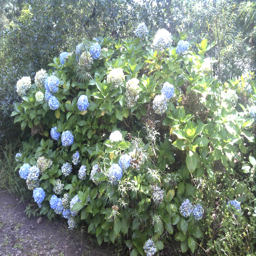

In [ ]:
Image.open('/kaggle/input/invasivemonitoring/test/test/708.jpg').resize((256,256))

In [ ]:
idx=0
for i in train_path:
    print(np.array(Image.open(i)).shape)
    idx+=1
    if idx>10:
        break

(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)
(866, 1154, 3)


* 모든 이미지의 shape = (866, 1154, 3)
* `target_size`를 256보다는 좀 더 키워보자.
    - `target_size`가 커지면 `batch_size`는 줄여야 한다.

---

### <font color=darkblue>Dataframe 만들기

#### <font color=blue>Train Dataset

In [ ]:
train_df = pd.DataFrame({"path" : train_path})
train_df['name'] = train_df['path'].apply(lambda x : x.split("/")[-1].split(".")[0])

label['name'] = label['name'].astype('str')

train_df = pd.merge(train_df, label, on = 'name')
train_df['invasive'] = train_df['invasive'].astype('str')
train_df.head()

,path,name,invasive
0,/kaggle/input/invasivemonitoring/train/train/1...,1269,1
1,/kaggle/input/invasivemonitoring/train/train/6...,623,1
2,/kaggle/input/invasivemonitoring/train/train/2...,2193,1
3,/kaggle/input/invasivemonitoring/train/train/2...,2008,0
4,/kaggle/input/invasivemonitoring/train/train/2...,2081,1


#### <font color=blue>Test Dataset

In [ ]:
test_df = pd.DataFrame({"path" : test_path})
test_df['name'] = test_df['path'].apply(lambda x : x.split("/")[-1].split(".")[0])
test_df

,path,name
0,/kaggle/input/invasivemonitoring/test/test/126...,1269
1,/kaggle/input/invasivemonitoring/test/test/623...,623
2,/kaggle/input/invasivemonitoring/test/test/764...,764
3,/kaggle/input/invasivemonitoring/test/test/107...,1075
4,/kaggle/input/invasivemonitoring/test/test/771...,771
...,...,...
1526,/kaggle/input/invasivemonitoring/test/test/25.jpg,25
1527,/kaggle/input/invasivemonitoring/test/test/120...,1201
1528,/kaggle/input/invasivemonitoring/test/test/147...,147
1529,/kaggle/input/invasivemonitoring/test/test/921...,921


---

### <font color=darkblue>Data preprocessing</font>
* `Data Augmentation`
    * 먼저 test set부터 적용해준다. 
    * 교차 검증을 할 것이기 때문에 train셋은 반복문 안에서 처리한다.


In [ ]:
idg_test = ImageDataGenerator()

test_generator = idg_test.flow_from_dataframe(test_df,
                                        x_col = 'path',
                                        y_col = None,
                                        class_mode=None,
                                        shuffle = False,
                                        target_size = (512,512)) # 기본 배치사이즈 32 

Found 1531 validated image filenames.


---

### <font color=darkblue>Data Augmentation 확인하기</font>

* ImageDataGenerator의 옵션들이 어떤 식으로 적용되는지 확인하는 것은 매우 중요하다.
* rotation을 적용했을 때, target이 중간 부분에 있는 이 대회에선 모델 학습에 도움이 될 수 있다. 
* rescale 옵션은 직접 모델 구축하는게 아닌 이상 대부분의 모델에서 구현이 되어있다. 따로 추가하지 않아도 된다.
* 다른 옵션들도 확인해보자.

In [ ]:
batch_size = 4
sample_df = train_df[:batch_size]
idg_sample = ImageDataGenerator(rotation_range = 45)

sample_generator = idg_sample.flow_from_dataframe(sample_df, 
                                                  batch_size = batch_size,
                                                 x_col = 'path',
                                                 y_col = 'invasive',
                                                 target_size = (150,150))

Found 4 validated image filenames belonging to 2 classes.


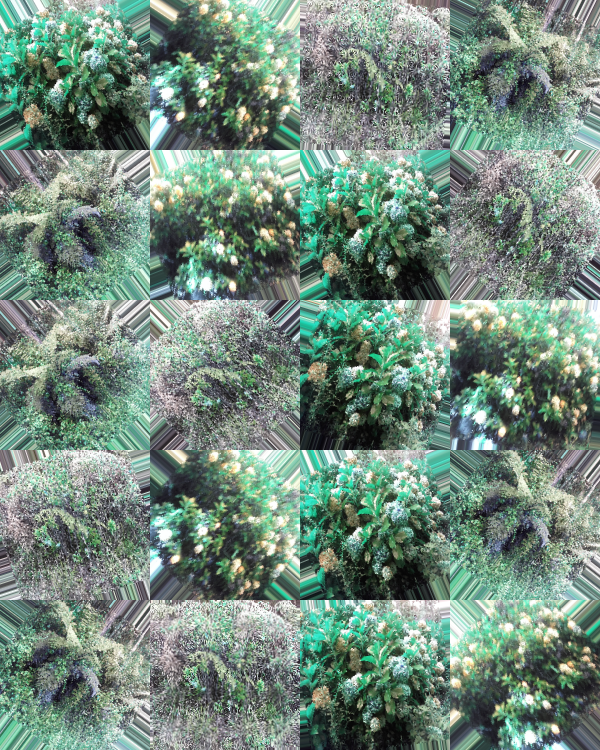

In [ ]:
images = []
for i in enumerate(range(5)):
    img, label = sample_generator.next()
    n_img = len(label)
    
    image_array = cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB)
    
    for idx in range(n_img-1):
        image_2 = cv2.cvtColor(img[idx+1], cv2.COLOR_BGR2RGB)
        image_array = np.hstack((image_array,image_2))
    images.append(image_array)
        
img = images[0]
for idx in range(len(images)-1):
    img  = np.vstack((img, images[idx+1]))

Image.fromarray((img).astype(np.uint8))

---

### <font color=darkblue>Model Training with K-fold Cross Validation</font>
* K : 5
* train : valid = 1836 : 459 비율로 나눠지게 된다.

In [ ]:
k_fold =StratifiedKFold(n_splits = 5, shuffle = True, random_state =42)

In [ ]:
result = 0
index=0
for train_index, valid_index in k_fold.split(train_df, train_df['invasive']):
    X_train = train_df.iloc[train_index]
    X_val = train_df.iloc[valid_index]
    
    
    # Data Preprocessing
    idg_train = ImageDataGenerator(horizontal_flip=True, rotation_range=45) 
    idg_val = ImageDataGenerator() 
    
    train_generator = idg_train.flow_from_dataframe(X_train,
                                                x_col = 'path',
                                                y_col = 'invasive',
                                                target_size=(512,512),
                                                batch_size = 16,)
                                                  
    valid_generator = idg_val.flow_from_dataframe(X_val,
                                              x_col = 'path',
                                              y_col = 'invasive',
                                              target_size=(512,512),
                                              batch_size = 16,)
    
    # callbacks
    early_stop = EarlyStopping(patience=7,
                          verbose = True)

    model_ckpt = ModelCheckpoint(filepath= 'best.h5',
                             monitor = 'val_loss',
                            save_best_only = True,
                            verbose = True)

    rl = ReduceLROnPlateau(verbose=True,patience=4,) 
 
    
    
    # model
    model = Sequential()
    model.add(EfficientNetB1(include_top = False, weights = 'imagenet', pooling = 'avg'))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(metrics = ['acc'], optimizer = 'adam', loss='categorical_crossentropy') 

    model.fit(train_generator,
             validation_data= valid_generator,
             callbacks=[early_stop, model_ckpt, rl],
             epochs = 15)
    
    # load_weights
    model.load_weights('best.h5')
    
    result += model.predict(test_generator, verbose = True,) /5
    index+=1
    print(f'{index} ... cross-validation complete ... ')

Found 1836 validated image filenames belonging to 2 classes.
Found 459 validated image filenames belonging to 2 classes.
Epoch 1/15
115/115 [==============================] - ETA: 0s - loss: 0.1769 - acc: 0.9406
Epoch 00001: val_loss improved from inf to 4.20868, saving model to best.h5
115/115 [==============================] - 249s 2s/step - loss: 0.1769 - acc: 0.9406 - val_loss: 4.2087 - val_acc: 0.7582
Epoch 2/15
115/115 [==============================] - ETA: 0s - loss: 0.1107 - acc: 0.9619
Epoch 00002: val_loss improved from 4.20868 to 0.33881, saving model to best.h5
115/115 [==============================] - 198s 2s/step - loss: 0.1107 - acc: 0.9619 - val_loss: 0.3388 - val_acc: 0.8388
Epoch 3/15
115/115 [==============================] - ETA: 0s - loss: 0.0780 - acc: 0.9766
Epoch 00003: val_loss improved from 0.33881 to 0.24725, saving model to best.h5
115/115 [==============================] - 198s 2s/step - loss: 0.0780 - acc: 0.9766 - val_loss: 0.2472 - val_acc: 0.9586
Epoc

115/115 [==============================] - 198s 2s/step - loss: 0.0202 - acc: 0.9946 - val_loss: 0.0381 - val_acc: 0.9847
Epoch 14/15
115/115 [==============================] - ETA: 0s - loss: 0.0094 - acc: 0.9973
Epoch 00014: val_loss did not improve from 0.03809
115/115 [==============================] - 197s 2s/step - loss: 0.0094 - acc: 0.9973 - val_loss: 0.0391 - val_acc: 0.9869
Epoch 15/15
115/115 [==============================] - ETA: 0s - loss: 0.0069 - acc: 0.9973
Epoch 00015: val_loss did not improve from 0.03809
48/48 [==============================] - 47s 974ms/step
2 ... cross-validation complete ... 
Found 1836 validated image filenames belonging to 2 classes.
Found 459 validated image filenames belonging to 2 classes.
Epoch 1/15
115/115 [==============================] - ETA: 0s - loss: 0.1924 - acc: 0.9292
Epoch 00001: val_loss improved from inf to 0.28175, saving model to best.h5
115/115 [==============================] - 201s 2s/step - loss: 0.1924 - acc: 0.9292 - va

115/115 [==============================] - ETA: 0s - loss: 0.0199 - acc: 0.9946
Epoch 00011: val_loss did not improve from 0.06332
115/115 [==============================] - 197s 2s/step - loss: 0.0199 - acc: 0.9946 - val_loss: 0.0717 - val_acc: 0.9739
Epoch 12/15
115/115 [==============================] - ETA: 0s - loss: 0.0255 - acc: 0.9907
Epoch 00012: val_loss did not improve from 0.06332
115/115 [==============================] - 199s 2s/step - loss: 0.0255 - acc: 0.9907 - val_loss: 0.0808 - val_acc: 0.9717
Epoch 13/15
115/115 [==============================] - ETA: 0s - loss: 0.0355 - acc: 0.9886
Epoch 00013: val_loss did not improve from 0.06332

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
115/115 [==============================] - 198s 2s/step - loss: 0.0355 - acc: 0.9886 - val_loss: 0.7558 - val_acc: 0.7821
Epoch 14/15
115/115 [==============================] - ETA: 0s - loss: 0.0255 - acc: 0.9924
Epoch 00014: val_loss did not improve from 

In [ ]:
result

array([[3.7590151e-05, 9.9996245e-01],
       [9.9689949e-01, 3.1004685e-03],
       [5.0094517e-10, 1.0000000e+00],
       ...,
       [1.6892184e-08, 1.0000000e+00],
       [1.9720024e-10, 1.0000000e+00],
       [9.9781048e-01, 2.1895403e-03]], dtype=float32)

### <font color=blue> Submission </font>

* result의 index값이 sample_submission.csv 이미지의 순서와 다르기 때문에 직접 제출 파일을 만드는 것이 쉽다.

In [ ]:
with zipfile.ZipFile('/kaggle/input/invasive-species-monitoring/sample_submission.csv.zip','r') as z:
    z.extractall('sub')

sub = pd.read_csv("sub/sample_submission.csv")
sub

,name,invasive
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5
...,...,...
1526,1527,0.5
1527,1528,0.5
1528,1529,0.5
1529,1530,0.5


In [ ]:
test_df['invasive'] = result[:,1]
sub_df = test_df.drop(['path'], axis=1)
sub_df

,name,invasive
0,1269,0.999962
1,623,0.003100
2,764,1.000000
3,1075,0.999977
4,771,1.000000
...,...,...
1526,25,1.000000
1527,1201,0.025586
1528,147,1.000000
1529,921,1.000000


In [ ]:
# Final score which evaluated on area under the ROC curve is 0.99714.
sub_df.to_csv("sub.csv",index=False) 